# Debugging GridSearchXGB; LossAccuracyOverRounds; plotting

Using the iris dataset from sklearn

## Imports, root directory

In [2]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread
import joblib

# import data handling tools
import numpy as np
import pandas as pd

#import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, log_loss

#sklearn imports
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn import datasets

#import XGBoost
import xgboost as xgb

# import Deep Learning Libraries for feature extraction
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16

PROJECT_ROOT_DIR = "Results_Iris"

## GridSearch and LossAccuracy functions

We only use 10 estimators so that the GridSearch returns an optimal value that isn't in the corners of the heatmap (this was necessary for debugging the plotting of the rectangle in the heatmap)

In [4]:
def GridSearchXGboost(x_train, y_train, n_folds, eta_vals, lambda_vals):
    """
    defines a function to perform cross validation with n-folds over 
    a grid of values for the learning rate and the L2 regularization.
    
    x_train, y_train: features and targets of the training data (some of it is used for validation at each k-fold instance)
    n_folds: number of folds to perform cross validation
    eta_vals, lambda_vals: numpy arrays containing the desired Learning rates and L2 regs. for grid searching
    """
    param_grid = {"learning_rate" : eta_vals, "reg_lambda": lambda_vals}
    
    
    model = xgb.XGBClassifier(max_depth = 1, random_state = 123, n_estimators = 10)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_folds, scoring='accuracy', verbose=3)

    
    grid_search.fit(x_train, y_train)

    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "GridSearchXGB")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)
    
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_csv = results_df.to_csv(FILE_PATH + "/crossval_XGB.csv")
    
    """
    saving the best accuracy score, eta  and its index for plotting and 
    for use in cross validation of different parameters
    
    
    getting the best (already trained) model to predict on the test data
    """
    
    test_array = np.zeros( ( len(eta_vals), len(lambda_vals) ) )
    
    best_acc = grid_search.best_score_
    best_params = grid_search.best_params_
    best_index =  np.unravel_index(grid_search.best_index_, test_array.shape)
    
    print(best_acc, best_params, best_index)
    
    with open(FILE_PATH + "/Best_settings_XGB.txt", "w") as file:
        file.write(f"Best value: L.R. = {best_params['learning_rate']}, L2 = {best_params['reg_lambda']}\n")
        file.write(f"Best validation accuracy: {best_acc}\n")
        file.write(f"Best indices: {best_index}")
        
    best_model = grid_search.best_estimator_
  
    joblib.dump(grid_search, FILE_PATH + '/grid_search_results_XGB.joblib')
    joblib.dump(best_model, FILE_PATH + '/best_model_XGB.joblib')

def LossAccuracyOverRounds(x_train, y_train, x_test, y_test, eta, lamb, maxrounds):
    model = xgb.XGBClassifier(n_estimators = 100, max_depth = 1, random_state = 123, objective = "multi:softmax", learning_rate = eta, reg_lambda = lamb)
    
    model.fit(x_train, y_train)
    train_accs, test_accs = [], []
    
    train_errors, test_errors = [], []
    for i in range(1, maxrounds + 1):
        train_pred = model.predict(x_train, iteration_range = (0,i))
        train_pred_proba = model.predict_proba(x_train, iteration_range = (0,i))
        test_pred = model.predict(x_test, iteration_range = (0,i))
        test_pred_proba = model.predict_proba(x_test, iteration_range = (0,i))
        
    # Calculate log loss and accuracy for the current round
        train_acc = accuracy_score(y_train, train_pred)
        train_accs.append(train_acc)
        
        train_error = log_loss(y_train, train_pred_proba)
        train_errors.append(train_error)
        
        test_acc = accuracy_score(y_test, test_pred)
        test_accs.append(test_acc)
        
        test_error = log_loss(y_test, test_pred_proba)
        test_errors.append(test_error)
    
    train_accs, train_errors, test_accs, test_errors = np.array(train_accs), np.array(train_errors), np.array(test_accs), np.array(test_errors)
    
    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "LossAccuracyXGB")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)
        
    np.save(FILE_PATH + '/train_accs_XGB.npy', train_accs)
    np.save(FILE_PATH + '/train_errors_XGB.npy', train_errors)
    np.save(FILE_PATH + '/test_accs_XGB.npy', test_accs)
    np.save(FILE_PATH + '/test_errors_XGB.npy', test_errors)

## Cross-validation and entropy/loss over iterations

In [6]:
inputs, outputs = datasets.load_iris(return_X_y=True)

strat = outputs
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size = .3, shuffle=True, stratify=strat, random_state=123)

eta_vals = np.linspace(0.05, 0.35, 7)
lambda_vals = np.logspace(-5, 0, 6)
lambda_vals = np.insert(lambda_vals, 0, 0)

GridSearchXGboost(x_train, y_train, 5, eta_vals, lambda_vals)
with open(PROJECT_ROOT_DIR + '/GridSearchXGB/Best_settings_XGB.txt','r') as file:
    lines = file.readlines()
    optimalparamsXGB = [float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    optimalindexXGB = [int(i) for i in lines[2].split(':')[1].lstrip(' (').rstrip(')').split(',')]

LossAccuracyOverRounds(x_train, y_train, x_test, y_test, optimalparamsXGB[0], optimalparamsXGB[1], 100)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.952 total time=   0.0s
[CV 2/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.905 total time=   0.0s
[CV 3/5] END learning_rate=0.05, reg_lambda=0.0;, score=1.000 total time=   0.0s
[CV 4/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.952 total time=   0.0s
[CV 5/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.857 total time=   0.0s
[CV 1/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.952 total time=   0.0s
[CV 2/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.905 total time=   0.0s
[CV 3/5] END learning_rate=0.05, reg_lambda=1e-05;, score=1.000 total time=   0.0s
[CV 4/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.952 total time=   0.0s
[CV 5/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.857 total time=   0.0s
[CV 1/5] END learning_rate=0.05, reg_lambda=0.0001;, score=0.952 total time=   0.0s
[CV 2/5] END learning_rate=0.05, r

## Plotting

We plot an accuracy heatmap, training and test confusion matrices and the cross-entropy/accuracy curves over iterations.

The produced files are reloaded so this cell can be reran without needing to cross-validate again.

In [8]:
inputs, outputs = datasets.load_iris(return_X_y=True)

strat = outputs
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size = .3, shuffle=True, stratify=strat, random_state=123)

PATH_3 = "Results_Iris/GridSearchXGB"
PATH_4 = "Results_Iris/LossAccuracyXGB"

grid_search_XGB = joblib.load(PATH_3 + '/grid_search_results_XGB.joblib')
best_model_XGB = joblib.load(PATH_3 + '/best_model_XGB.joblib')
CVdataframe_XGB = pd.read_csv(PATH_3 + '/crossval_XGB.csv')

with open(PATH_3 + '/Best_settings_XGB.txt','r') as file:
    lines = file.readlines()
    optimalparamsXGB = [float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    optimalindexXGB = [int(i) for i in lines[2].split(':')[1].lstrip(' (').rstrip(')').split(',')]

train_predictions_XGB = best_model_XGB.predict(x_train)
test_predictions_XGB = best_model_XGB.predict(x_test)

train_accs_XGB, train_errors_XGB = np.load(PATH_4 + '/train_accs_XGB.npy'), np.load(PATH_4 + '/train_errors_XGB.npy')
test_accs_XGB, test_errors_XGB = np.load(PATH_4 + '/test_accs_XGB.npy'), np.load(PATH_4 + '/test_errors_XGB.npy')

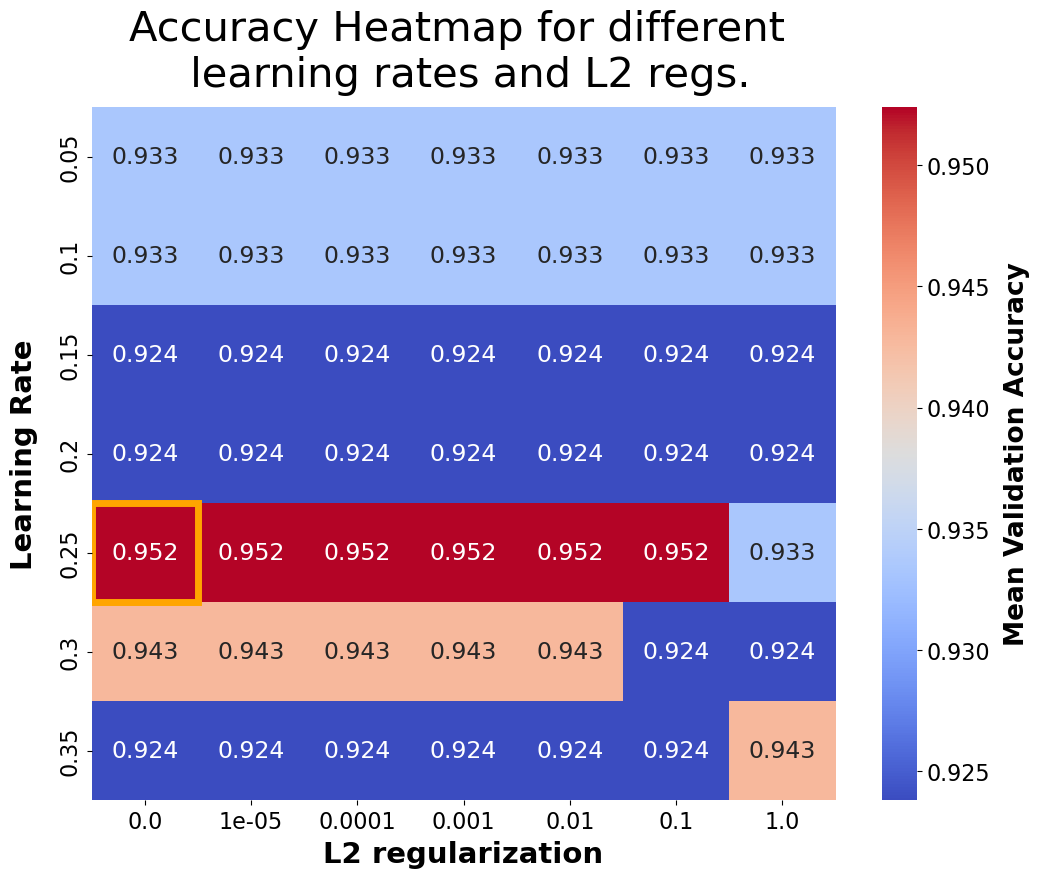

In [9]:
################### VALIDATION ACCURACY HEATMAP ######################

heatmap_data = CVdataframe_XGB.pivot(index = 'param_learning_rate', columns = 'param_reg_lambda', values = 'mean_test_score')


fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(heatmap_data, ax = ax, annot=True, fmt=".3f", cmap="coolwarm", annot_kws={"size": 17})

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Mean Validation Accuracy', fontsize=19, labelpad = 10, fontweight = 'bold')
cbar.ax.tick_params(axis='both', labelsize = 16)

ax.tick_params(axis = 'both', labelsize = 16)
ax.set_title("Accuracy Heatmap for different \n learning rates and L2 regs.", fontsize = 30, pad = 15)
ax.set_xlabel("L2 regularization", fontsize = 21, labelpad = 5, fontweight = 'bold')
ax.set_ylabel("Learning Rate", fontsize = 21, labelpad = 15, fontweight = 'bold')
ax.add_patch(plt.Rectangle((optimalindexXGB[1], optimalindexXGB[0]), 1, 1, fill=False, edgecolor='orange', lw=5))
plt.savefig(PATH_3 + "/Accuracy_heatmap_XGB.png")
plt.show()

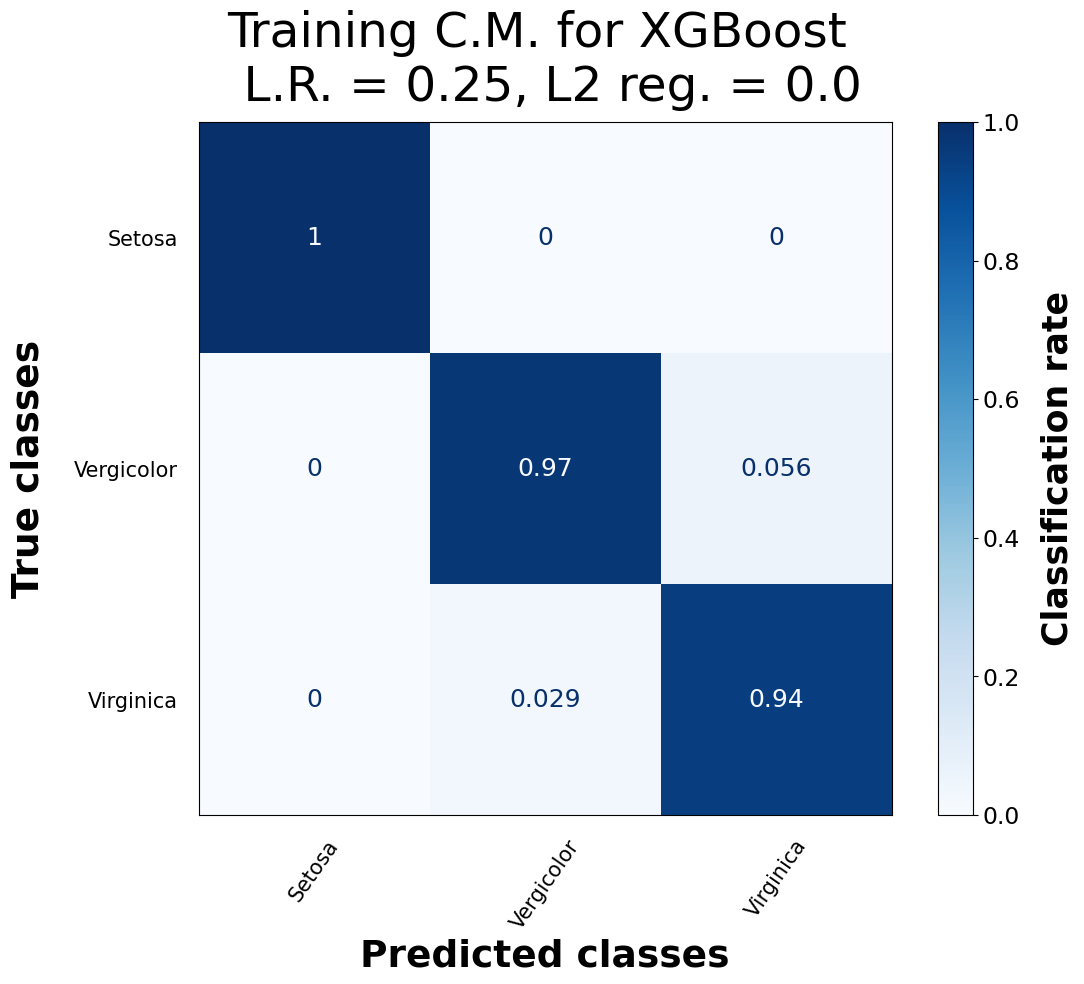

In [10]:
################## CONFUSION MATRICES ##################################################
fig0, ax0 = plt.subplots(figsize=(12, 9))

classes = ['Setosa', 'Vergicolor', 'Virginica']
# Plot training confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_train, train_predictions_XGB, ax=ax0, display_labels = classes, cmap='Blues', normalize = "pred", xticks_rotation=55, text_kw = dict(fontsize = 18), colorbar = False)

image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.set_ylabel('Classification rate', fontsize=25, labelpad = 15, fontweight = 'bold')
cbar.ax.tick_params(labelsize = 17)

ax0.set_title(f'Training C.M. for XGBoost \n L.R. = {optimalparamsXGB[0]}, L2 reg. = {optimalparamsXGB[1]}', fontsize = 35, pad = 15)
ax0.tick_params(axis='both', which='both', length=0, labelsize = 15, pad = 15)
ax0.set_xlabel('Predicted classes', fontsize = 27, fontweight = 'bold')
ax0.set_ylabel('True classes', fontsize = 27, labelpad = 20, fontweight = 'bold')
plt.savefig(PATH_3 + "/Training_CM_XGB.png")
plt.show()

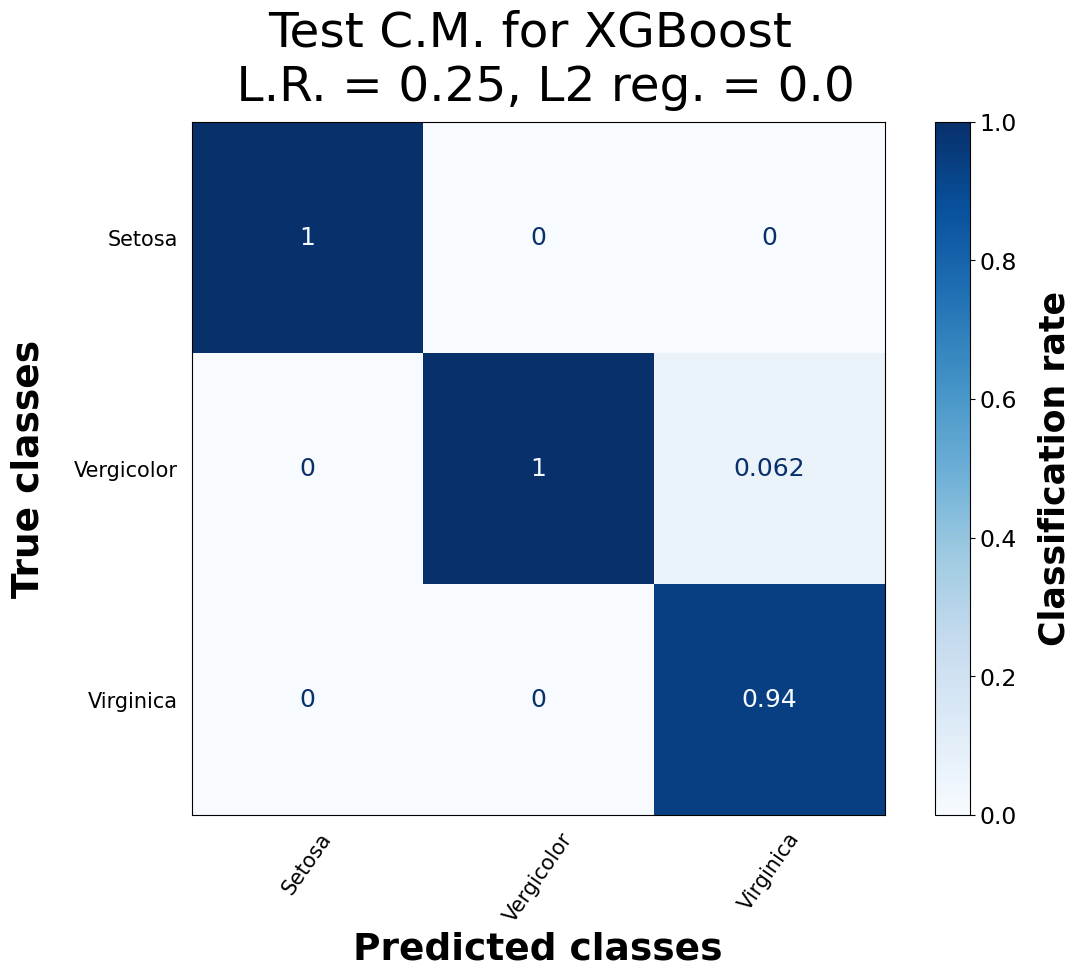

In [11]:
fig1, ax1 = plt.subplots(figsize=(13, 9))

disp = ConfusionMatrixDisplay.from_predictions(y_test, test_predictions_XGB, ax=ax1, display_labels = classes, cmap='Blues', normalize = "pred", xticks_rotation=55, text_kw = dict(fontsize = 18), colorbar = False)

image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.set_ylabel('Classification rate', fontsize=25, labelpad = 15, fontweight = 'bold')
cbar.ax.tick_params(labelsize = 17)

ax1.set_title(f'Test C.M. for XGBoost \n L.R. = {optimalparamsXGB[0]}, L2 reg. = {optimalparamsXGB[1]}', fontsize = 35, pad = 15)
ax1.tick_params(axis = 'both', which = 'both', length = 0, labelsize = 15, pad = 10)
ax1.set_xlabel('Predicted classes', fontsize = 27, fontweight = 'bold')
ax1.set_ylabel('True classes', fontsize = 27, labelpad = 20, fontweight = 'bold')
plt.savefig(PATH_3 + "/Test_CM_XGB.png")
plt.show()

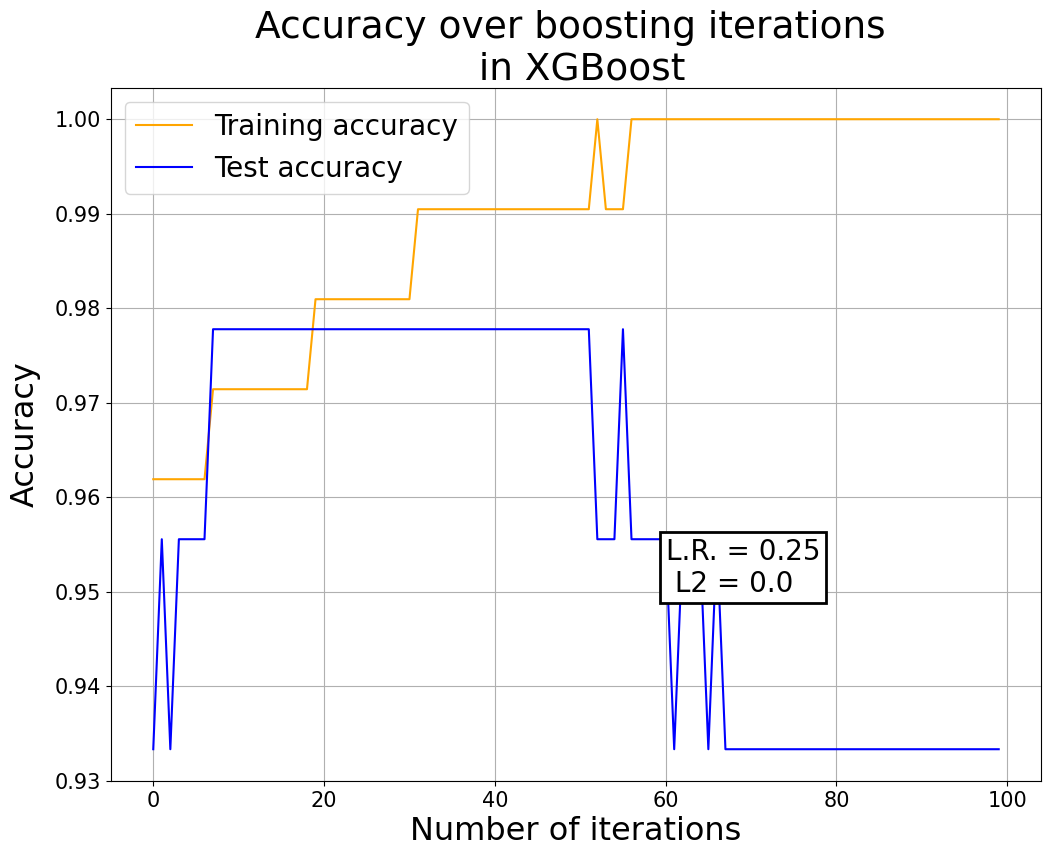

In [12]:
########################### CROSS ENTROPY AND ACCURACY OVER ROUNDS #######################################
plt.figure(1, figsize = (12, 9))
plt.plot(range(0,100), train_accs_XGB, color = 'orange', label = 'Training accuracy')
plt.plot(range(0,100), test_accs_XGB, color = 'blue', label = 'Test accuracy')
plt.legend(fontsize = 20)
plt.title(f'Accuracy over boosting iterations \n in XGBoost', fontsize = 27)
plt.text(60, 0.95, f'L.R. = {optimalparamsXGB[0]}\n L2 = {optimalparamsXGB[1]}', fontsize = 20, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('Number of iterations', fontsize = 23)
plt.ylabel('Accuracy', fontsize = 23, labelpad = 10)
plt.grid()
plt.savefig(PATH_4 + "/Accuracy_over_estimators_XGB.png")
plt.show()

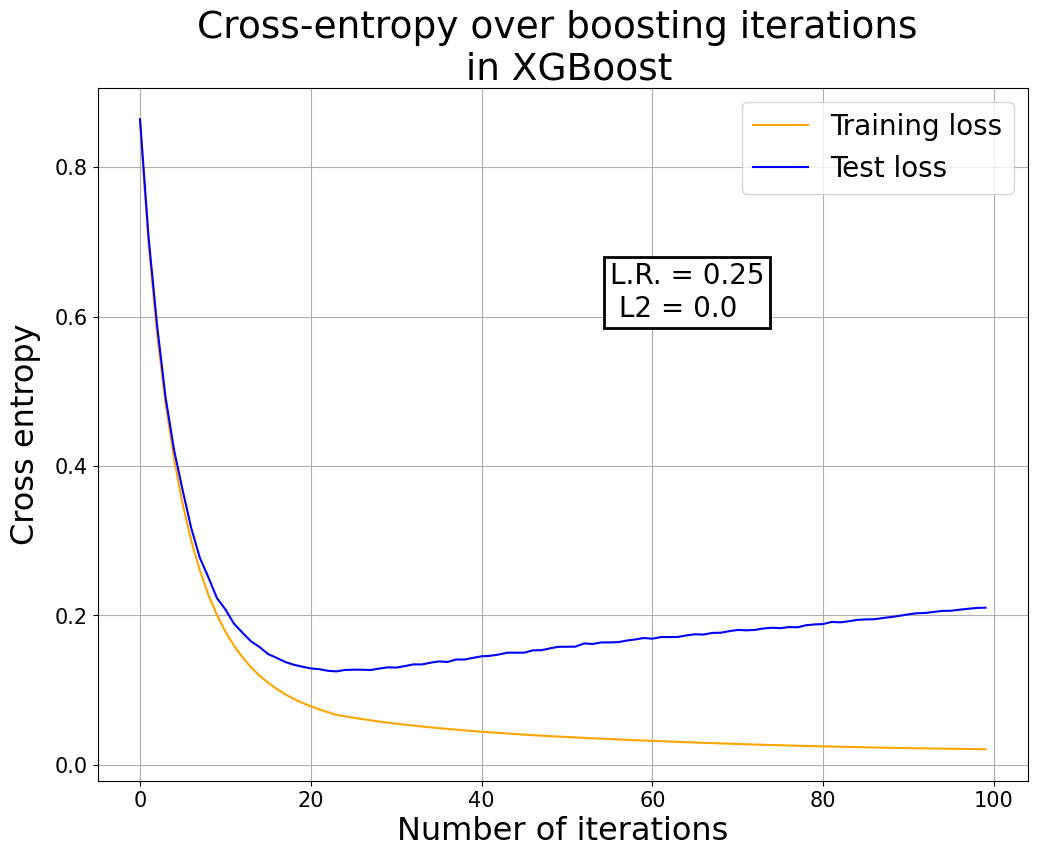

In [13]:
plt.figure(1, figsize = (12, 9))
plt.plot(range(0,100), train_errors_XGB, color = 'orange', label = 'Training loss')
plt.plot(range(0,100), test_errors_XGB, color = 'blue', label = 'Test loss')
plt.legend(fontsize = 20)
plt.title(f'Cross-entropy over boosting iterations \n in XGBoost', fontsize = 27)
plt.text(55, 0.6, f'L.R. = {optimalparamsXGB[0]}\n L2 = {optimalparamsXGB[1]}', fontsize = 20, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.tick_params(axis = 'both', labelsize = 15)
plt.xlabel('Number of iterations', fontsize = 23)
plt.ylabel('Cross entropy', fontsize = 23, labelpad = 10)
plt.grid()
plt.savefig(PATH_4 + "/Entropy_over_estimators_XGB.png")
plt.show()